# 肺結節の良悪性判定
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/LIDC_PN')
CLASS_LABELS = ('benign', 'malignant')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する
画像ファイルは`<クラス名>/<ファイル名>`の形式でデータディレクトリ内に用意されている

In [3]:
def create_dataset_df(data_root, class_labels, image_ext):
    dfs = []
    for cls, class_label in enumerate(class_labels):
        df = pd.DataFrame(
            [(str(p), class_label, cls)
             for p in data_root.glob(class_label + '/*' + image_ext)],
            columns=['filepath', 'class_label', 'class'])
        dfs.append(df)
    df_dataset = pd.concat(dfs, ignore_index=True)
    return df_dataset


df_dataset = create_dataset_df(DATA_ROOT, CLASS_LABELS, IMAGE_EXT)
assert set(CLASS_LABELS) == set(df_dataset['class_label'].unique(
)), 'Discrepancy between CLASS_LABELS and df_dataset'
display(df_dataset)

,filepath,class_label,class
0,Data\Images\LIDC_PN\benign\001.png,benign,0
1,Data\Images\LIDC_PN\benign\002.png,benign,0
2,Data\Images\LIDC_PN\benign\007.png,benign,0
3,Data\Images\LIDC_PN\benign\011.png,benign,0
4,Data\Images\LIDC_PN\benign\012.png,benign,0
...,...,...,...
604,Data\Images\LIDC_PN\malignant\177.png,malignant,1
605,Data\Images\LIDC_PN\malignant\178.png,malignant,1
606,Data\Images\LIDC_PN\malignant\179.png,malignant,1
607,Data\Images\LIDC_PN\malignant\180.png,malignant,1


### クラスごとの画像数を確認する

In [4]:
df_dataset['class_label'].value_counts()

benign       432
malignant    177
Name: class_label, dtype: int64

### 画像を表示してみる
各クラスからランダムに選択した画像を表示する。

benign


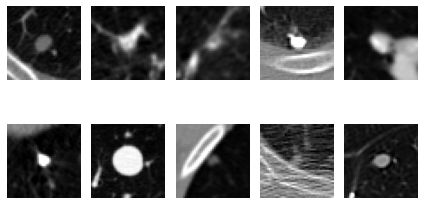

malignant


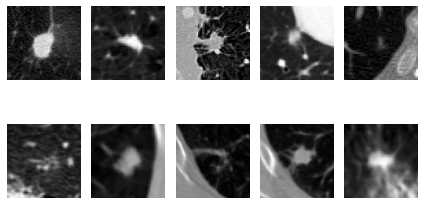

In [5]:
from PIL import Image


def show_images_each_class(df, n_rows=2, n_cols=5):
    for class_label, group in df.groupby('class_label'):
        print(class_label)
        for i, row in enumerate(group.sample(n=n_rows * n_cols).itertuples()):
            plt.subplot(n_rows, n_cols, i + 1)
            image = Image.open(row.filepath)
            row.filepath
            plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


show_images_each_class(df_dataset)

### ホールドアウト検証用にデータセットを分割する
今回はデータセットの$\frac{2}{3}$を学習用、$\frac{1}{3}$を評価用に使用する。
分割にはsklearnの[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)を使う。

In [6]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 3
kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)
train_index, test_index = next(
    kfold.split(df_dataset['filepath'], df_dataset['class']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

### データを読み込む
読み込んだ画像は０から255の値をとるため読み込んだあとに255で割ることで0から1の値をとるようにする

In [7]:
IMG_SHAPE = (1, 64, 64)


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)


train_data = np.stack(
    [load_img(filepath) for filepath in df_train['filepath']])
train_labels = df_train['class'].tolist()
test_data = np.stack([load_img(filepath) for filepath in df_test['filepath']])
test_labels = df_test['class'].tolist()

train_data = (train_data / 255).astype(np.float32)
test_data = (test_data / 255).astype(np.float32)

print('training data', train_data.shape, len(train_labels),
      np.mean(train_labels))
print('test data', test_data.shape, len(test_labels), np.mean(test_labels))

training data (406, 64, 64, 1) 406 0.29064039408866993
test data (203, 64, 64, 1) 203 0.29064039408866993


## Channels firstに変更
画素の並びをChannels lastからChannels first(PyTorchで使われる形式)に変更

In [8]:
train_data = np.transpose(train_data, (0, 3, 1, 2))
test_data = np.transpose(test_data, (0, 3, 2, 1))
print(train_data.shape, test_data.shape)

(406, 1, 64, 64) (203, 1, 64, 64)


## ネットワーク作成
今回は画像サイズが小さいためネットワークを自作する必要があるが、本来は既存のモデルを流用したほうがよい。

In [9]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    class ConvBNReLU(nn.Module):
        def __init__(self, in_chs, out_chs, kernel_size=3):
            super().__init__()
            self.block = nn.Sequential(
                nn.Conv2d(in_chs, out_chs, kernel_size=kernel_size),
                nn.BatchNorm2d(out_chs), nn.ReLU(inplace=True),
                nn.Conv2d(out_chs, out_chs, kernel_size=kernel_size),
                nn.BatchNorm2d(out_chs), nn.ReLU(inplace=True))

        def forward(self, x):
            return self.block(x)

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(self.ConvBNReLU(1, 4), nn.MaxPool2d(2),
                                     self.ConvBNReLU(4, 8), nn.MaxPool2d(2),
                                     self.ConvBNReLU(8, 16), nn.MaxPool2d(2),
                                     nn.Dropout(.25), nn.Flatten(start_dim=1),
                                     nn.Linear(256, 32), nn.ReLU(inplace=True),
                                     nn.Linear(32, 1))

    def forward(self, x):
        return self.network(x)


net = SimpleCNN()
from torchsummary import summary
summary(net, IMG_SHAPE, verbose=0, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─ConvBNReLU: 2-1                   [-1, 4, 60, 60]           --
|    |    └─Sequential: 3-1              [-1, 4, 60, 60]           204
|    └─MaxPool2d: 2-2                    [-1, 4, 30, 30]           --
|    └─ConvBNReLU: 2-3                   [-1, 8, 26, 26]           --
|    |    └─Sequential: 3-2              [-1, 8, 26, 26]           912
|    └─MaxPool2d: 2-4                    [-1, 8, 13, 13]           --
|    └─ConvBNReLU: 2-5                   [-1, 16, 9, 9]            --
|    |    └─Sequential: 3-3              [-1, 16, 9, 9]            3,552
|    └─MaxPool2d: 2-6                    [-1, 16, 4, 4]            --
|    └─Dropout: 2-7                      [-1, 16, 4, 4]            --
|    └─Flatten: 2-8                      [-1, 256]                 --
|    └─Linear: 2-9                       [-1, 32]                  8,224
|    └─

### ネットワーク構造の可視化
PyTorch本体にはネットワーク構造可視化の機能はないので[PyTorchViz](https://github.com/szagoruyko/pytorchviz)を使う

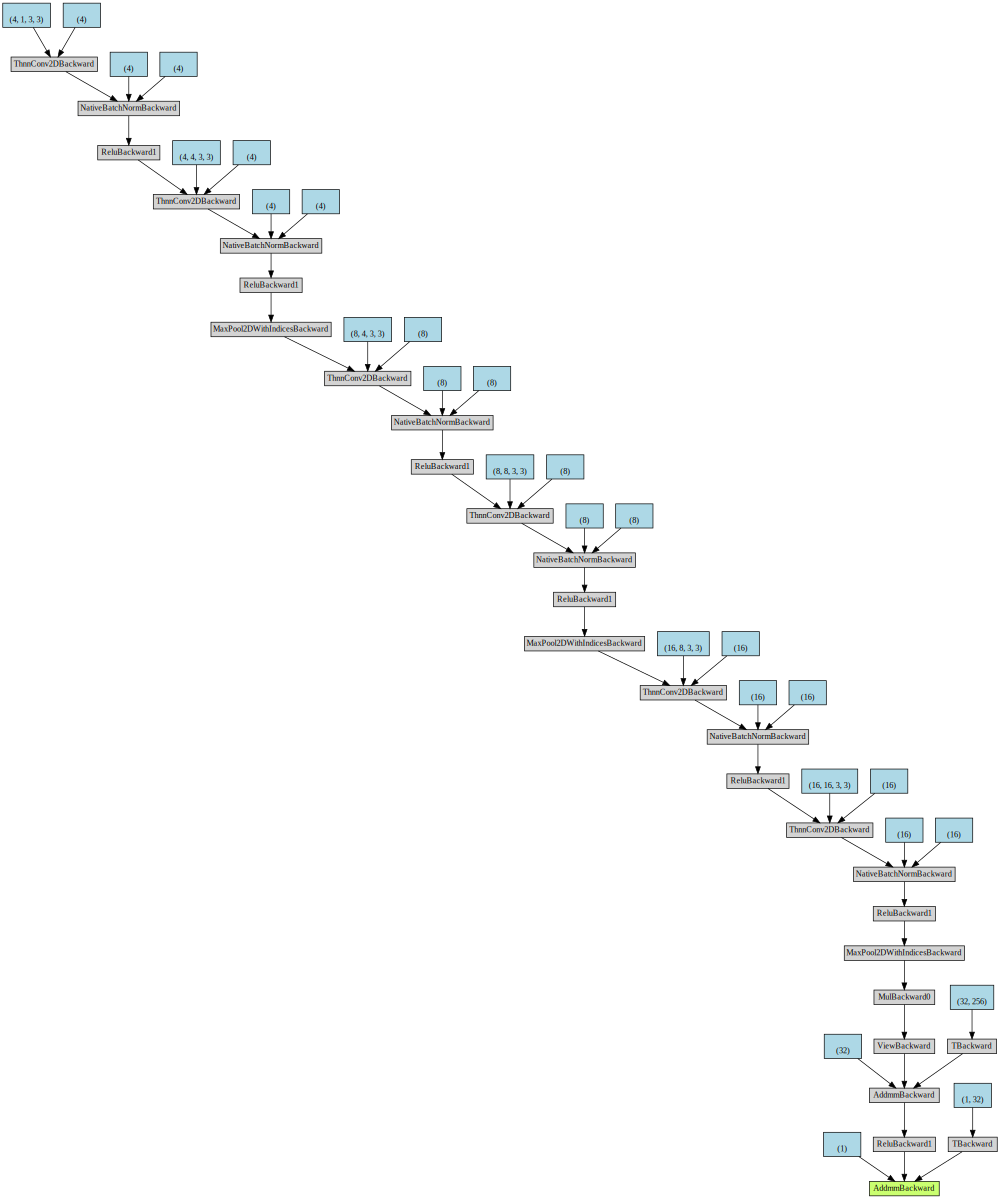

In [10]:
import torchviz
dummy_x = torch.zeros(1, *IMG_SHAPE, dtype=torch.float, requires_grad=False)
dummy_y = net(dummy_x)
dot = torchviz.make_dot(dummy_y)
dot.format = 'svg'
dot

## デバイスの設定
cudaが使える環境ではcudaを、それ以外の環境ではCPUを使う。  
ネットワークと入出力の両方を`to(device)`でdeviceに移動する必要がある。

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
device

device(type='cuda', index=0)

### 損失関数とOptimizer

In [12]:
import torch.optim as optim

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

## DataLoaderの作成
DataLoaderはデータをmini batchに分割する。(他の機能は今回は使わない)

In [13]:
train_data = torch.from_numpy(train_data).to(device)
train_labels = torch.FloatTensor(train_labels).to(device)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)

test_data = torch.from_numpy(test_data).to(device)
test_labels = torch.FloatTensor(test_labels).to(device)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

In [14]:
import os
BATCH_SIZE = 8
NUM_WORKERS = 0 if os.name == 'nt' else 2

trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=NUM_WORKERS)

## 学習
<div class="alert alert-block alert-warning">
<b>注意:</b> 今回、epoch数は決め打ちしてありますが、本来はvalidationデータを用いて学習を終了させる必要があります。
</div>

In [15]:
import sklearn.metrics as metrics

EPOCHS = 16

logs = []
for epoch in range(EPOCHS):
    epoch_logs = []
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            acc = metrics.accuracy_score(
                (labels.cpu().numpy()).astype(np.uint8),
                (torch.sigmoid(outputs) > .5).cpu().numpy().astype(np.uint8))
            epoch_logs.append((loss.item(), acc))
    means = [np.mean(v) for v in zip(*epoch_logs)]
    print(epoch + 1, means)
    logs.append(means)

print('Finish Training')

1 [0.6284318507886401, 0.7001633986928105]
2 [0.4502704415251227, 0.7908496732026145]
3 [0.4431070437033971, 0.7990196078431373]
4 [0.4224901628114429, 0.8161764705882353]
5 [0.3539216709049309, 0.852124183006536]
6 [0.32284164034268437, 0.8423202614379085]
7 [0.29961798833135295, 0.869281045751634]
8 [0.26530590741073384, 0.9003267973856208]
9 [0.25872835867545185, 0.8717320261437909]
10 [0.2162282999020581, 0.9117647058823529]
11 [0.233091899650354, 0.8897058823529411]
12 [0.22418282692338906, 0.8946078431372549]
13 [0.22900151074224828, 0.9084967320261438]
14 [0.19482114122194402, 0.8995098039215687]
15 [0.20342960776578561, 0.9166666666666666]
16 [0.20640618440366404, 0.9117647058823529]
Finish Training


### 学習履歴の可視化

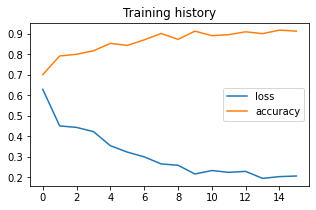

In [16]:
pd.DataFrame(logs, columns=['loss', 'accuracy']).plot(title='Training history',
                                                      figsize=(5, 3))
plt.show()

## 評価
### 混同行列

#### 学習データでの評価
学習できているかを確認するため。

In [17]:
from sklearn import metrics


def evaluate(model, data, labels):
    with torch.no_grad():
        predictions = torch.sigmoid(model(data)).cpu().numpy().squeeze()
    y_pred = predictions > .5
    df_result = pd.DataFrame({
        'truth': labels,
        'pred_proba': predictions,
        'pred_class': y_pred
    })
    cm = metrics.confusion_matrix(df_result['truth'], df_result['pred_class'])
    df_cm = pd.DataFrame(cm, index=CLASS_LABELS, columns=CLASS_LABELS)
    df_cm.index.name, df_cm.columns.name = 'Truth', 'Prediction'
    display(df_cm)
    print('Accuracy = {n} / {d} = {a:.03g}%'.format(n=cm.trace(),
                                                    d=cm.sum(),
                                                    a=100 * cm.trace() /
                                                    cm.sum()))
    return df_result


net.eval()

train_result = evaluate(net, train_data, train_labels.cpu())

Prediction,benign,malignant
Truth,,
benign,274,14
malignant,9,109


Accuracy = 383 / 406 = 94.3%


#### テストデータでの評価

In [18]:
test_result = evaluate(net, test_data, test_labels.cpu())

Prediction,benign,malignant
Truth,,
benign,126,18
malignant,8,51


Accuracy = 177 / 203 = 87.2%


### ROCカーブ

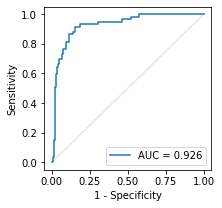

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(test_result['truth'],
                                         test_result['pred_proba'])
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, label='AUC = {auc:.03g}'.format(auc=auc))
plt.plot((0, 1), (0, 1), zorder=0, color='black', alpha=.1,
         linestyle='-')  # diagonal line
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.show()